In [1]:
import time
notebookstart= time.time()
from collections import defaultdict

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
print("Data:\n",os.listdir("./input"))

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

Data:
 ['periods_train.csv.zip', 'test_active.csv', 'test.csv', 'train.csv', 'train_features.csv', 'test.csv.zip', 'periods_test.csv.zip', 'test_active.csv.zip', 'train_active.csv', 'test_features.csv', 'periods_test.csv', 'periods_train.csv', 'train.csv.zip', 'train_active.csv.zip']


/home/cerdgio/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [80]:
NFOLDS = 10
SEED = 2018
VALID = False
NROW =None

In [81]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"
    

In [82]:
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [83]:
print("\nData Load Stage")
df = pd.read_csv('./input/train_features.csv', index_col = "item_id", parse_dates = ["activation_date"],
                      nrows=NROW)
traindex = df.index
testing = pd.read_csv('./input/test_features.csv', index_col = "item_id", parse_dates = ["activation_date"],
                     nrows=NROW)
testdex = testing.index

ntrain = df.shape[0]
ntest = testing.shape[0]

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

y = df.deal_probability.copy()
df.drop(["deal_probability", 'subtarget'],axis=1, inplace=True)


Data Load Stage


In [84]:
print('Train shape: {} Rows, {} Columns'.format(*df.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([df,testing],axis=0)
del testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Train shape: 1503424 Rows, 498 Columns
Test shape: 508438 Rows, 499 Columns
Combine Train and Test


/home/cerdgio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """



All Data shape: 2011862 Rows, 499 Columns


In [85]:
# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index

In [86]:
df.drop(['activation_date', 'subtarget'],axis=1, inplace=True)

In [87]:
for col in df.columns:
    if (df[col].dtypes=='object'):
        df[col].fillna('-999', inplace=True)
    elif (df[col].dtype.name=='category'):
        df[col] = df[col].astype(str)
        df[col].fillna(-999, inplace=True)
    else:
        df[col].fillna(-999, inplace=True)

In [88]:
LE =defaultdict(preprocessing.LabelEncoder)
cat_col = []
cat_name = []
for n, col in enumerate(df.columns):
    if df[col].dtype.name=='object':
        cat_col.append(n)
        cat_name.append(col)
df[cat_name] = df[cat_name].apply(lambda x: LE[x.name].fit_transform(x))
print(cat_col)

[0, 7, 14, 21, 22, 35, 42, 56, 80, 93, 100, 108, 109, 116, 129, 136, 143, 150, 157, 158, 165, 178, 185, 198, 205, 212, 213, 220, 233, 240, 248, 272, 273, 274, 275, 282, 289, 296, 309, 316, 323, 324, 331, 344, 351, 358, 359, 366, 379, 386, 394, 395, 402, 403, 416, 423, 436, 443, 450, 475, 476, 483]


In [89]:
for i in df.columns:
    if df[i].dtypes=='float64':
        df[i] = df[i].astype('float16')
    elif df[i].dtypes=='int64':
        df[i] = df[i].astype('int16')

In [90]:
df.loc[traindex].shape, y.shape

((1503424, 497), (1503424,))

In [91]:
print("\nModeling Stage")


gc.collect();
    
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.016,
    'verbose': 0
}  


if VALID == True:
    X_train, X_valid, y_train, y_valid = train_test_split(
        df.loc[training_index], y, test_size=0.10, random_state=23)
        
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train.values, y_train.values,
                     categorical_feature=cat_col)
    lgvalid = lgb.Dataset(X_valid.values, y_valid.values,
                     categorical_feature=cat_col)
    del df, X_train; gc.collect()
    
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=20000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
    del X_valid ; gc.collect()

else:
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(df.loc[traindex], y,
                   # feature_name=df.columns, 
                          categorical_feature=cat_col)
    gc.collect()
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=1550,
        verbose_eval=100
    )


Modeling Stage
Light Gradient Boosting Regressor


/home/cerdgio/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [92]:
from sklearn.externals import joblib

In [93]:
joblib.dump(lgb_clf, './models/lgbm_1.pkl')
joblib.dump(LE, './models/le.pkl')

['./models/le.pkl']

Model Evaluation Stage
Notebook Runtime: 328.01 Minutes


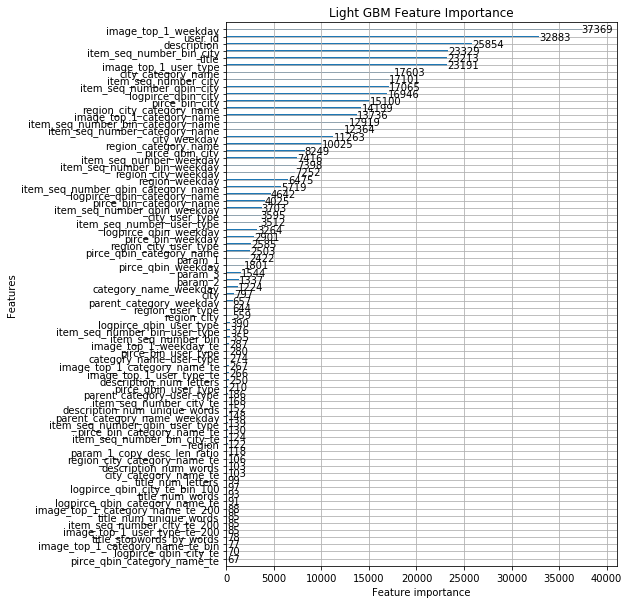

In [94]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=75, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

print("Model Evaluation Stage")
lgpred = lgb_clf.predict(df.loc[testdex]) 

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

## time.strftime('%H:%m')

In [ ]:
time.time().s

In [95]:
other = pd.read_csv('best_public_blend.csv', index_col=['item_id'])
print(other.shape)
other.head()

(508438, 1)


,deal_probability
item_id,
6544e41a8817,0.310496
65b9484d670f,0.104259
8bab230b2ecd,0.185657
8e348601fefc,0.094654
8bd2fe400b89,0.246941


In [96]:
lgsub.head()

,deal_probability
item_id,
6544e41a8817,0.225865
65b9484d670f,0.126324
8bab230b2ecd,0.206646
8e348601fefc,0.158676
8bd2fe400b89,0.283214


In [97]:
lgsub.deal_probability = 0.9*other.deal_probability.values+0.1*lgsub.deal_probability.values
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True)
lgsub.to_csv("second.csv",index=True,header=True)

In [98]:
import matplotlib.pyplot as plt
% matplotlib inline

In [100]:
df.loc[traindex].shape

(1503424, 497)

In [105]:
y.shape

(1503424,)

In [ ]:
np.linspace

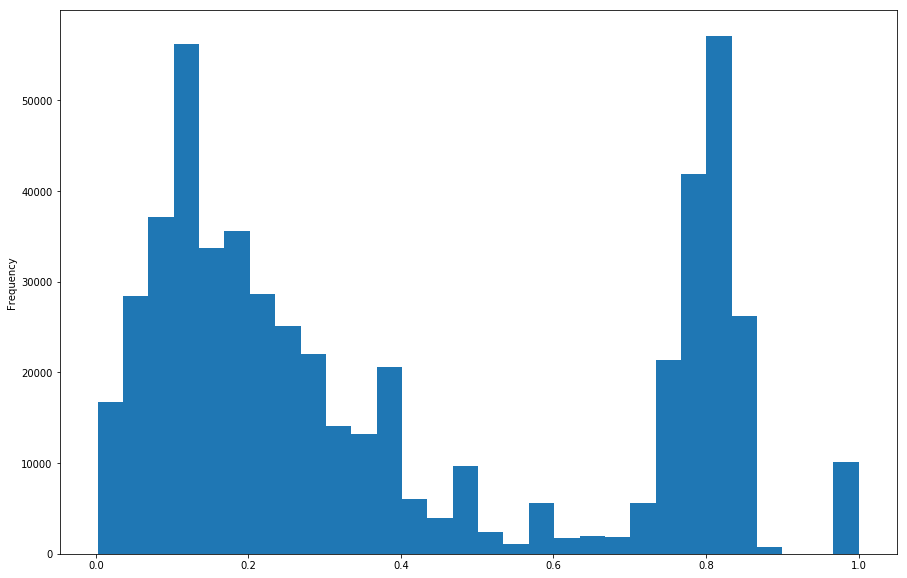

In [114]:
y[y!=0].plot(kind='hist', figsize=(15,10), bins=30)

In [120]:
import os 

In [124]:
os.listdir('./Others_solutions')

['ridgelgb.csv',
 'lgsub (1).csv',
 'lgsub (2).csv',
 'catsub.csv',
 'lgsub.csv',
 'best_public_blend.csv',
 'first.csv',
 'Avito_Shanth_RNN_AVERAGE.csv',
 'xgb_tfidf0.218538.csv',
 'Anaconda3-5.2.0-Linux-x86_64.sh']

In [135]:
lgsub['deal_probability'] = 0
acc = 0
for file in os.listdir('./Others_solutions')[:-1]:
    print(file)
    temp = pd.read_csv('./Others_solutions/'+file, index_col=['item_id'])
    lgsub['deal_probability'] +=temp.deal_probability.values
    acc +=1
lgsub['deal_probability'] /= acc

ridgelgb.csv
lgsub (1).csv
lgsub (2).csv
catsub.csv
lgsub.csv
best_public_blend.csv
first.csv
Avito_Shanth_RNN_AVERAGE.csv
xgb_tfidf0.218538.csv


In [146]:
lgsub['deal_probability'] = 0
acc = 0
temp = pd.DataFrame()
for file in os.listdir('./Others_solutions')[:-1]:
    print(file)
    temp[str(acc)] = pd.read_csv('./Others_solutions/'+file, index_col=['item_id'])['deal_probability']
    acc +=1
lgsub['deal_probability'] =temp.max(axis=1)
#lgsub['deal_probability'] /= acc

ridgelgb.csv
lgsub (1).csv
lgsub (2).csv
catsub.csv
lgsub.csv
best_public_blend.csv
first.csv
Avito_Shanth_RNN_AVERAGE.csv
xgb_tfidf0.218538.csv


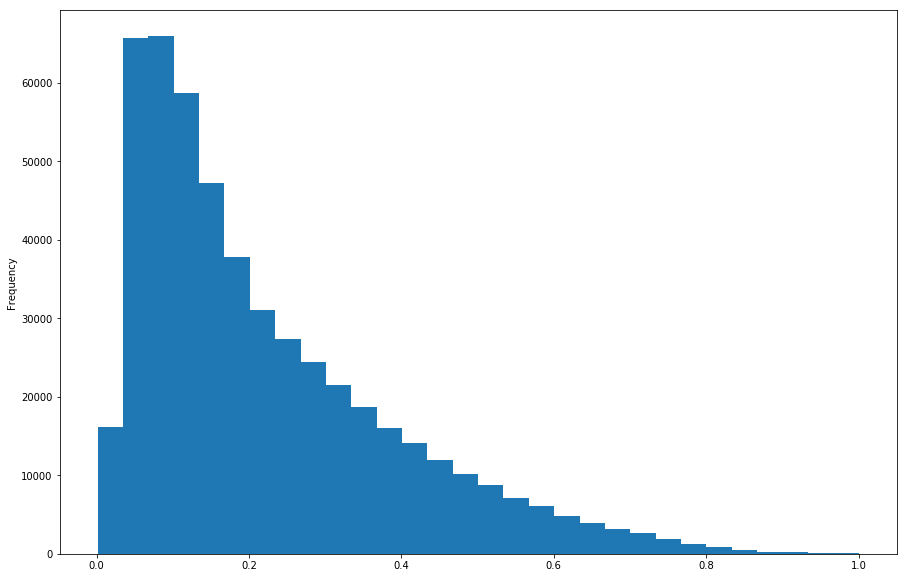

In [147]:
lgsub['deal_probability'].plot(kind='hist', figsize=(15,10), bins=30)
lgsub.to_csv("max_blend.csv",index=True,header=True)

In [138]:
lgsub.head()

,deal_probability
item_id,
6544e41a8817,0.283657
65b9484d670f,0.144719
8bab230b2ecd,0.171814
8e348601fefc,0.096929
8bd2fe400b89,0.261096


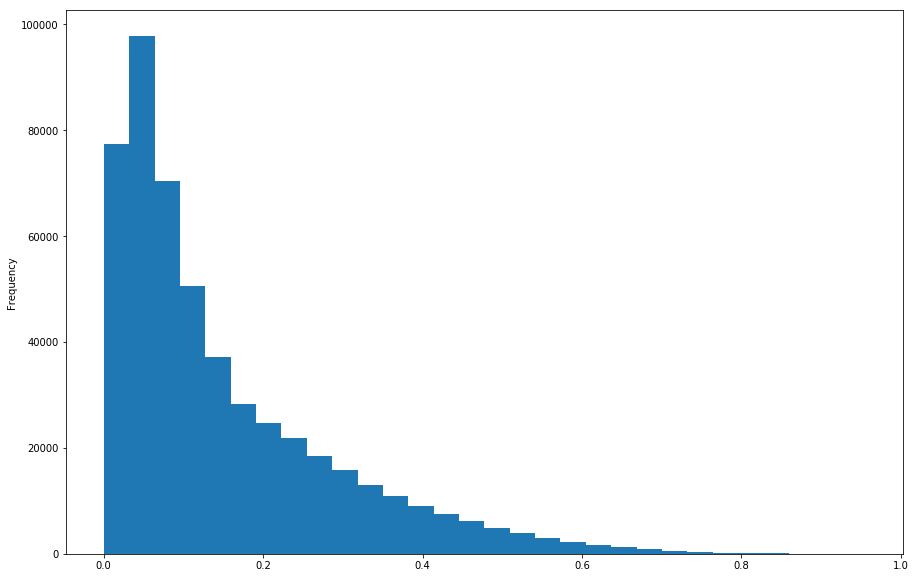

In [118]:
lgsub = pd.read_csv('second.csv', index_col=['item_id'])
lgsub['deal_probability'].plot(kind='hist', figsize=(15,10), bins=30)

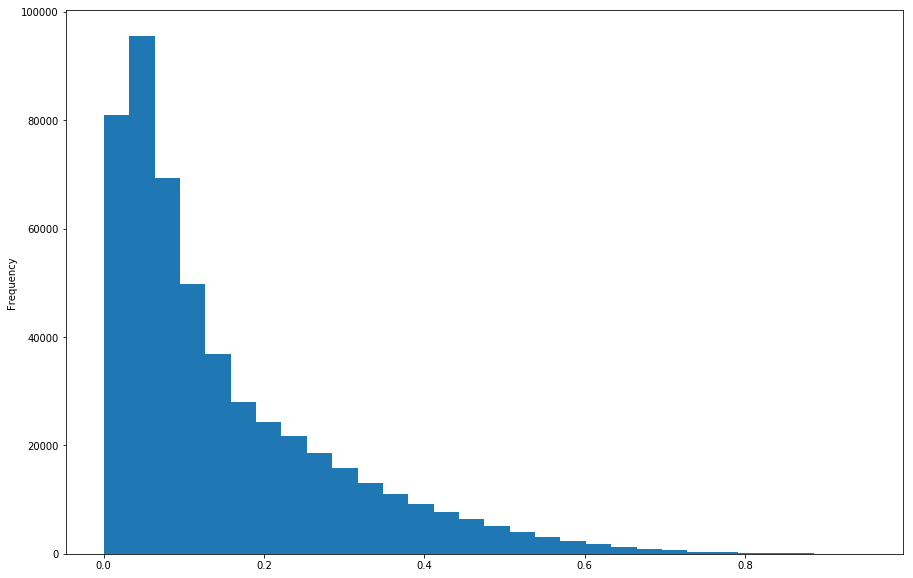

In [119]:
lgsub = pd.read_csv('best_public_blend.csv', index_col=['item_id'])
lgsub['deal_probability'].plot(kind='hist', figsize=(15,10), bins=30)